In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tgt
from IPython.display import Audio, display
from torchaudio.transforms import AmplitudeToDB, MelSpectrogram
from torchcodec.decoders import AudioDecoder

from zerosyl.encoder import ZeroSylDiscrete, ZeroSylCollapsed

In [2]:
# Get all the waveform and alignment paths

waveform_dir = Path("data/waveforms/LibriSpeech/dev-clean")
alignment_dir = Path("data/alignments/LibriSpeech/dev-clean")

waveform_paths = {p.stem: p for p in waveform_dir.rglob("*.flac")}
alignment_paths = {p.stem: p for p in alignment_dir.rglob("*.TextGrid")}

common_stems = sorted(waveform_paths.keys() & alignment_paths.keys())
waveform_paths = [waveform_paths[s] for s in common_stems]
alignment_paths = [alignment_paths[s] for s in common_stems]


In [3]:
# Process a random example

index = np.random.randint(len(waveform_paths))
waveform_path = waveform_paths[index]
alignment_path = alignment_paths[index]

tg = tgt.read_textgrid(alignment_path, include_empty_intervals=False)
words = [interval.text for interval in tg.get_tier_by_name("words")]
print(f"Processing {waveform_path.name}, {" ".join(words)}")

Processing 1462-170142-0025.flac, hilda's face quivered but she whispered yes i think it must have been


In [4]:
# Functions for plotting

def plot_boundaries(melspec, textgrid, tokens, starts, ends, model):
    plt.figure(figsize=(12, 6), constrained_layout=True)
    plt.subplot(2, 1, 1)
    plt.imshow(melspec, aspect="auto", origin="lower")
    xticks = []
    xtickslabels = []
    for interval in textgrid.get_tier_by_name("syllables"):
        x1 = interval.start_time * 50
        x2 = interval.end_time * 50
        xticks.append((x1 + x2) / 2)
        xtickslabels.append(interval.text)
        plt.axvline(x1, color="white")
        plt.axvline(x2, color="white")
    plt.xticks(xticks, xtickslabels, rotation=90)
    plt.gca().get_yaxis().set_visible(False)
    plt.gca().xaxis.set_ticks_position("top")
    plt.gca().xaxis.set_label_position("top")
    plt.title("Syllables from forced alignments")
    plt.xlim(0, textgrid.end_time * 50)
    plt.subplot(2, 1, 2)
    plt.imshow(melspec, aspect="auto", origin="lower")
    xticks = []
    xtickslabels = []
    for token, start, end in zip(tokens, starts, ends):
        x1 = start.item()
        x2 = end.item()
        xticks.append((x1 + x2) / 2)
        xtickslabels.append(str(token.item()))
        plt.axvline(x1, color="white")
        plt.axvline(x2, color="white")
    plt.xticks(xticks, xtickslabels, rotation=90)
    plt.gca().get_yaxis().set_visible(False)
    plt.title(f"{model} boundaries and tokens")
    plt.xlim(0, textgrid.end_time * 50)
    plt.show()


In [5]:
textgrid = tgt.read_textgrid(alignment_path, include_empty_intervals=False)

decoder = AudioDecoder(waveform_path, sample_rate=16000, num_channels=1)
audio = decoder.get_all_samples()
wav = audio.data.cuda()

tMelSpectrogram = MelSpectrogram(16000, 1024, 400, 320, n_mels=100)
tAmplitudeToDB = AmplitudeToDB(top_db=80)

melspec = tAmplitudeToDB(tMelSpectrogram(audio.data))[0]

display(Audio(waveform_path))

transcription = " ".join([interval.text for interval in textgrid.get_tier_by_name("words")])
print(f"Transcription: {transcription}")

Transcription: hilda's face quivered but she whispered yes i think it must have been


## Model without collapsing silences

In [6]:
if "model" not in locals():
    model = ZeroSylDiscrete.from_pretrained_checkpoint(
        checkpoint_path="checkpoints/WavLM-Large.pt",
        centroids_path="checkpoints/km10000-centroids-v040.pt"
    ).cuda()

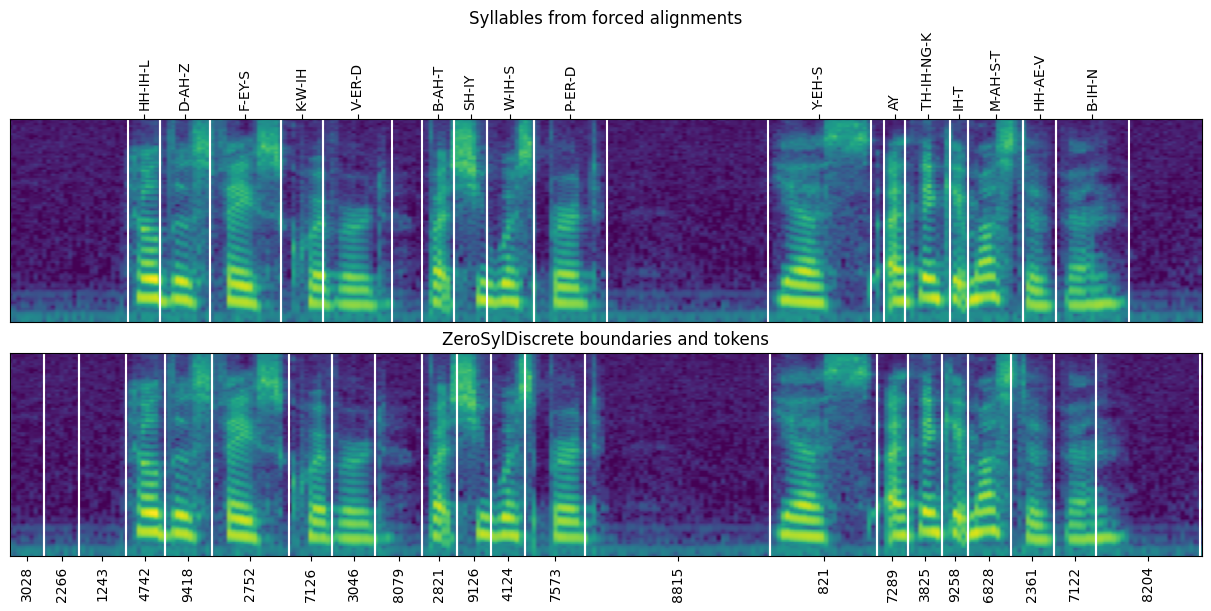

In [7]:
starts, ends, ids = model.encode(wav)
plot_boundaries(melspec, textgrid, ids, starts, ends, model="ZeroSylDiscrete")

## Model with silences collapsed

In [8]:
if "model_with_collapsing" not in locals():
    model_with_collapsing = ZeroSylCollapsed.from_pretrained_checkpoint(
        checkpoint_path="checkpoints/WavLM-Large.pt",
        centroids_path="checkpoints/km10000-centroids-v040.pt",
        silences_path="checkpoints/km10000-silences-v040.pt"
    ).cuda()

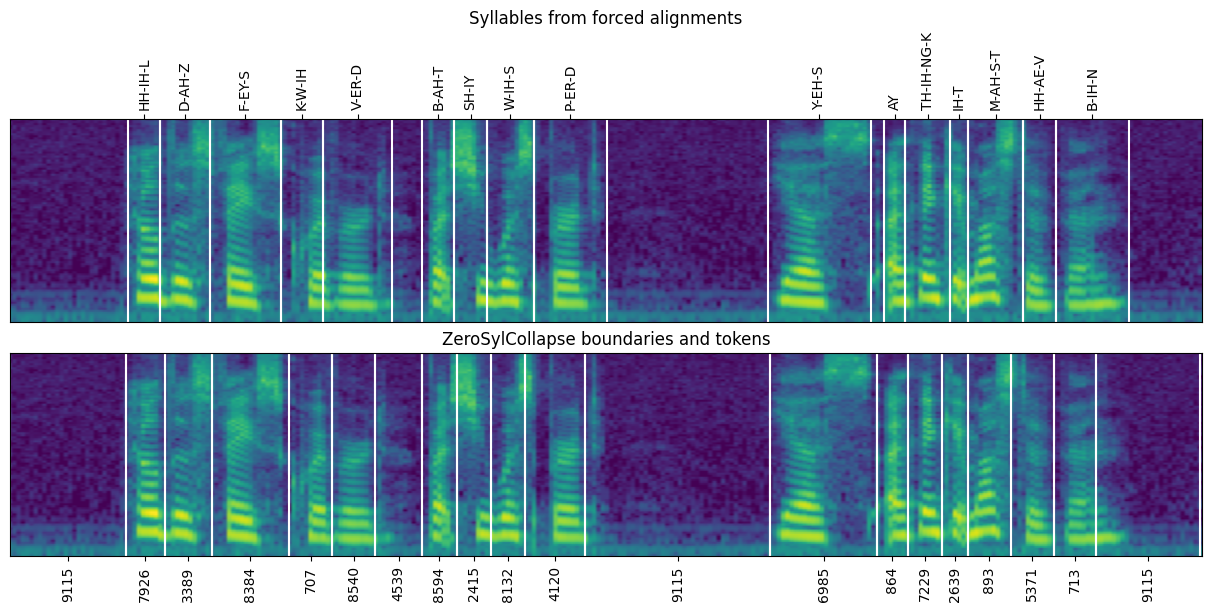

In [9]:
starts, ends, ids = model_with_collapsing.encode(wav)
plot_boundaries(melspec, textgrid, ids, starts, ends, model="ZeroSylCollapse")